In [1]:
import datetime
import backtrader as bt

In [2]:
datapath = "/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/data/stock/ORCL.csv"

data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values after this date
    todate=datetime.datetime(2000, 12, 31),
    reverse=False
)

In [3]:
class PrototypeStrategy(bt.Strategy):
    
    params = (
        ("maperiod", 15),
    )
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.maperiod)
        
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return None
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            
            # What's this bar executed?
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None
    
    def notify_trade(self, trade):
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
#         print(self.position)
        # Check if we are in the market
        if not self.position:
            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close
                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()
        else:
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

2000-02-18, Close, 25.61
2000-02-22, Close, 25.94
2000-02-23, Close, 27.58
2000-02-24, Close, 27.08
2000-02-25, Close, 30.88
2000-02-28, Close, 30.01
2000-02-29, Close, 32.47
2000-03-01, Close, 31.27
2000-03-02, Close, 29.95
2000-03-02, BUY CREATE, 29.95
2000-03-03, BUY EXECUTED, 31.10
2000-03-03, OPERATION PROFIT, GROSS 0.00, NET -0.31
2000-03-03, Close, 32.80
2000-03-06, Close, 33.12
2000-03-07, Close, 32.77
2000-03-08, Close, 36.35
2000-03-09, Close, 36.73
2000-03-10, Close, 35.69
2000-03-10, SELL CREATE, 35.69
2000-03-13, SELL EXECUTED, 34.33
2000-03-13, OPERATION PROFIT, GROSS 32.30, NET 31.65
2000-03-13, Close, 34.44
2000-03-13, BUY CREATE, 34.44
2000-03-14, BUY EXECUTED, 35.80
2000-03-14, OPERATION PROFIT, GROSS 0.00, NET -0.36
2000-03-14, Close, 33.67
2000-03-15, Close, 34.38
2000-03-16, Close, 35.83
2000-03-17, Close, 34.90
2000-03-20, Close, 34.16
2000-03-21, Close, 35.28
2000-03-21, SELL CREATE, 35.28
2000-03-22, SELL EXECUTED, 35.42
2000-03-22, OPERATION PROFIT, GROSS -3.80

<IPython.core.display.Javascript object>


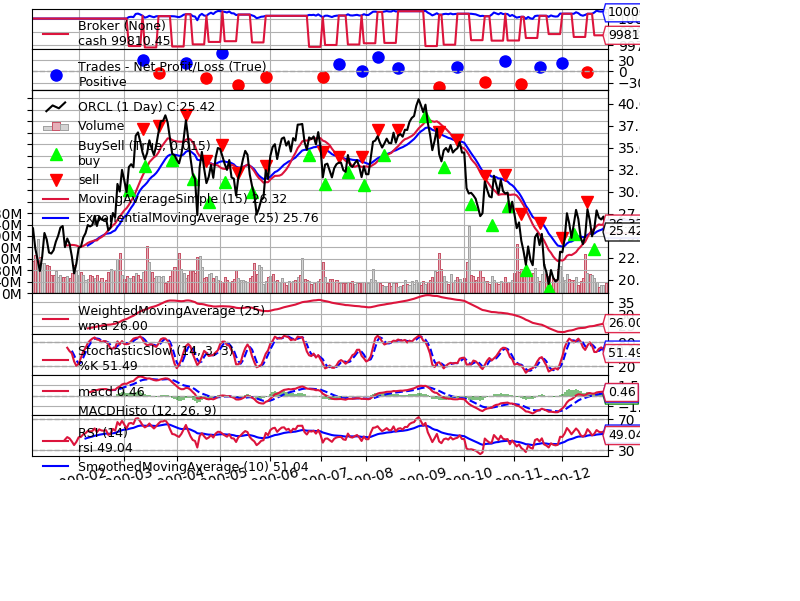

[[<Figure size 640x480 with 8 Axes>]]

In [4]:
cerebro = bt.Cerebro()
cerebro.addstrategy(PrototypeStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.001)
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()